In [1]:
pip install 'git+https://github.com/facebookresearch/segment-anything.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-b5l341lq
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-b5l341lq
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 7fa17d78c45f4f642faa89f4c0e590c400f74225
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=6c51431be9deeb50ca97e2f269c023c3be09e6291b00a978c9008314673ecfa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-b9ucwa4c/wheels/d5/11/03/7aca746a2c0e09f279b10436ced7175926bc38f650b736a648
Successfully built segment-anything


In [2]:
# downloading the trained model

!wget 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

--2023-04-11 17:35:52--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.249.63, 13.224.249.96, 13.224.249.94, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.249.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   237MB/s    in 11s     

2023-04-11 17:36:02 (233 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [3]:
# import pytorch

import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118
CUDA is available: True


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

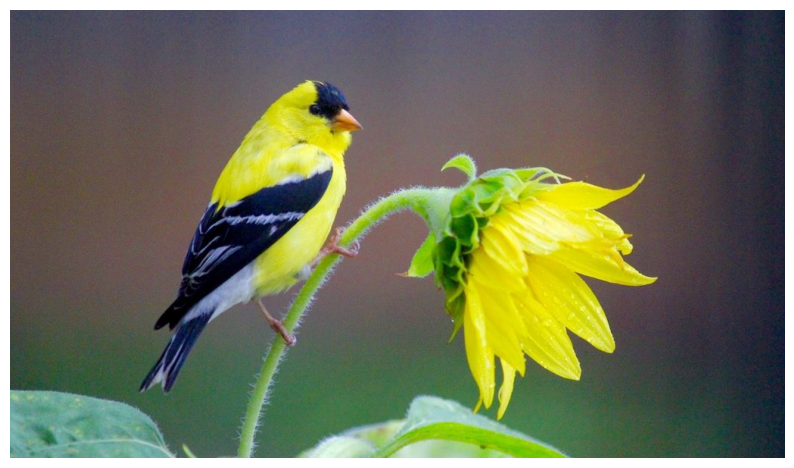

In [5]:
image = cv2.imread('/content/Americangoldfinch_hannah-jones.jpg')  #Try any image you like
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

In [7]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [15]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.95,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [16]:
masks = mask_generator_.generate(image)

In [17]:
print(len(masks))

20


In [18]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

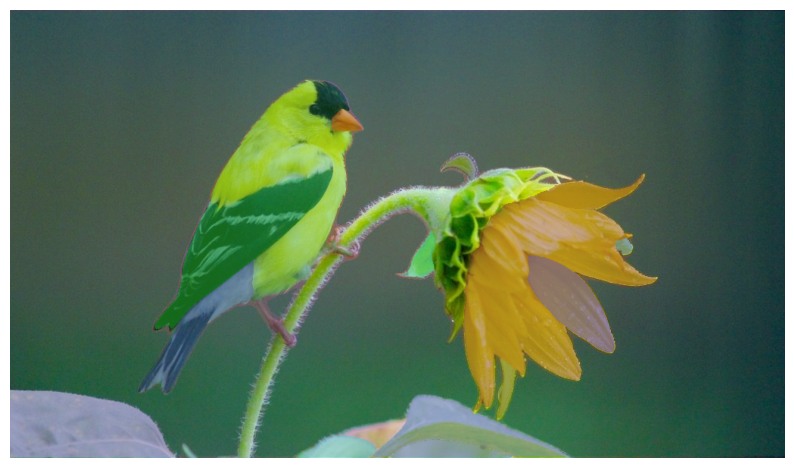

In [19]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 